
<b>INSTITUTO FEDERAL DE GOIÁS<br/>
PÓS-GRADUAÇÃO EM INTELIGÊNCIA ARTIFICIAL APLICADA<br/></b>
Disciplina: Processamento de Linguagem Natural  <br/>
Professor: Daniel Xavier de Sousa <br/>
Alunos: Wagner Silva, Cleibson, Marcos Rodrigues


---

In [2]:
# Bibliotecas básicas
import pandas as pd
import numpy as np

# Bibliotecas relacionadas ao treinamento do modelo
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, f1_score, recall_score, precision_score, classification_report, average_precision_score, precision_recall_curve, roc_curve, auc
from transformers import DistilBertTokenizer, DistilBertModel
from gensim.models import KeyedVectors

# Bibliotecas relacionadas a exibição de gráficos
import matplotlib.pyplot as plt

In [3]:
# Carregando modelo de transformer pré-treinado e tokenizer (DistilBERT)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [4]:
# Carregando modelo pré-treinado de vetores de palavras (utilizado no feature-based encoding)
word_vectors = KeyedVectors.load_word2vec_format('../embeddings/wiki.pt.vec', binary=False)

In [5]:
# Carregando dataset
df = pd.read_csv('../datasets/buscape_preprocessed_balanced.csv')

In [6]:
df.shape

(133632, 2)

In [7]:
# Montando um batch de apenas 1000 instâncias
batch_1 = df[:10000]

In [8]:
# Verificando quantidades de rating
batch_1['rating'].value_counts()

rating
1    9087
0     913
Name: count, dtype: int64

In [9]:
# Limpando lista de sentenças e definindo labels
texts = batch_1['review_text'].tolist()
labels = batch_1['rating'].tolist()

In [10]:
def clear_sentences(sentences):
    new_list_texts = []
    for item in sentences:
        item_fixed = item[1:-1]  
        new_list_texts.append(item_fixed)
    
    return [s[1:-1] for s in new_list_texts]

In [11]:
texts = clear_sentences(texts)

In [12]:
print(len(texts))
print(len(labels))

10000
10000


In [13]:
# Dividindo dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [14]:
# Conferindo quantidades
print(f'textos para treino: {len(train_texts)}')
print(f'textos para teste: {len(test_texts)}')
print(f'labels para treino: {len(train_labels)}')
print(f'labels para teste: {len(test_labels)}')

textos para treino: 8000
textos para teste: 2000
labels para treino: 8000
labels para teste: 2000


In [15]:
# Função que gera incorporações baseadas em recursos usando vetores de palavras pré-treinados
def generate_feature_based_embedding(text):
    words = text.split()
    embeddings = [word_vectors[word] for word in words if word in word_vectors]
    return np.mean(embeddings, axis=0) if embeddings else np.zeros(300)

In [16]:
# Gerando feature-based embeddings para treino
train_feature_based_embeddings = np.array([generate_feature_based_embedding(text) for text in train_texts])

In [17]:
# Gerando feature-based embeddings para teste
test_feature_based_embeddings = np.array([generate_feature_based_embedding(text) for text in test_texts])

In [18]:
# Tokenizando
train_inputs = tokenizer(train_texts, padding=True, truncation=True, max_length=50, return_tensors="pt")

In [19]:
# CLS: 101
# SEP: 102
train_inputs.input_ids[0:3]

tensor([[  101,  4013,  8566,  3406, 24970, 15781, 10861,  8915, 19817, 10936,
          9530, 13028,  2080,  7861, 28681,  3022,  2004,  9765, 22684,  2229,
          2079,  2019,  2080,  1051, 10861,  2175, 13473,  2072,  4013,  8566,
          3406, 24970, 15781, 10861,  8915, 19817, 10936,  9530, 13028,  2080,
          7861, 28681,  3022,  2004,  9765, 22684,  2229,  2079,  2019,   102],
        [  101, 11498,  9530,  7367, 25698,  2099,  2004,  2522, 14268,  2015,
          1041,  4274,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  7861, 28994,  2050,  1041, 14163,  9956, 21766,  5714,  2561,
          3672,  2063,  7367,  2213,  6970,  8303,  2063,  7861, 10663,  2099,
          1051,  8915,  2226,  3291,  2050,  1051,

In [20]:
# Gerando transformer-based embeddings
with torch.no_grad():
    train_outputs = model(**train_inputs).last_hidden_state
transformer_embeddings = train_outputs.numpy()

In [21]:
# Foi gerado uma matriz de 3 dimensão, optei pelo reshape desta matriz de transformers embeddings
transformer_embeddings.shape

(8000, 50, 768)

In [22]:
# Reshape da matriz 
reshaped_transformer_embeddings = transformer_embeddings.reshape(transformer_embeddings.shape[0], -1)

In [23]:
reshaped_transformer_embeddings.shape

(8000, 38400)

In [24]:
# Concatenando train_feature_based_embeddings e reshaped_transformer_embeddings
combined_embeddings = np.concatenate((train_feature_based_embeddings, reshaped_transformer_embeddings), axis=1)

In [25]:
combined_embeddings.shape

(8000, 38700)

In [26]:
# Definindo treino utilizando MLP com PyTorch
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.dropout1 = nn.Dropout(p=0.05)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return self.sigmoid(x)

In [27]:
input_dim = 300 + reshaped_transformer_embeddings.shape[1]  # Dimensões combinadas
hidden_dim1 = 128
hidden_dim2 = 64
mlp_model = MLP(input_dim, hidden_dim1, hidden_dim2)

In [28]:
# Convertendo dados para PyTorch tensors
train_embeddings = torch.tensor(combined_embeddings, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.float32)

In [29]:
# Definindo função loss e optmizer
criterion = nn.BCELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=5e-4)

In [30]:
# Lista para armazenar métricas
losses = []
accuracies = []

# Treinando o modelo
num_epochs = 30
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = mlp_model(train_embeddings)
    loss = criterion(outputs, train_labels.view(-1, 1))
    loss.backward()
    optimizer.step()
    
    predicted_labels = (outputs >= 0.5).float()
    accuracy = (predicted_labels == train_labels).float().mean()
    
    losses.append(loss.item())
    accuracies.append(accuracy.item())
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}')

Epoch [1/30], Loss: 0.6982, Accuracy: 0.3163
Epoch [2/30], Loss: 0.3348, Accuracy: 0.9094
Epoch [3/30], Loss: 0.3285, Accuracy: 0.9094
Epoch [4/30], Loss: 0.3068, Accuracy: 0.9094
Epoch [5/30], Loss: 0.3014, Accuracy: 0.9094
Epoch [6/30], Loss: 0.2928, Accuracy: 0.9094
Epoch [7/30], Loss: 0.2894, Accuracy: 0.9094
Epoch [8/30], Loss: 0.2832, Accuracy: 0.9094
Epoch [9/30], Loss: 0.2843, Accuracy: 0.9094
Epoch [10/30], Loss: 0.2796, Accuracy: 0.9094
Epoch [11/30], Loss: 0.2823, Accuracy: 0.9094
Epoch [12/30], Loss: 0.2741, Accuracy: 0.9094
Epoch [13/30], Loss: 0.2749, Accuracy: 0.9094
Epoch [14/30], Loss: 0.2719, Accuracy: 0.9094
Epoch [15/30], Loss: 0.2720, Accuracy: 0.9094
Epoch [16/30], Loss: 0.2677, Accuracy: 0.9094
Epoch [17/30], Loss: 0.2650, Accuracy: 0.9094
Epoch [18/30], Loss: 0.2643, Accuracy: 0.9092
Epoch [19/30], Loss: 0.2601, Accuracy: 0.9093
Epoch [20/30], Loss: 0.2593, Accuracy: 0.9094
Epoch [21/30], Loss: 0.2552, Accuracy: 0.9087
Epoch [22/30], Loss: 0.2535, Accuracy: 0.90

In [31]:
def plot_metrics_train_graph(metrics, label):
    plt.plot(metrics, label=label)
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.title(f'Training {label}')
    plt.legend()
    plt.show()

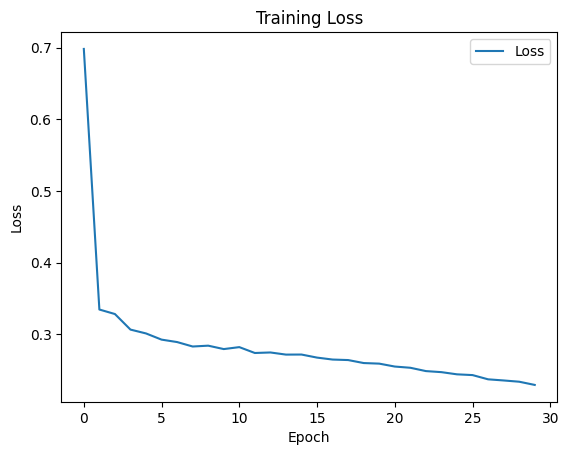

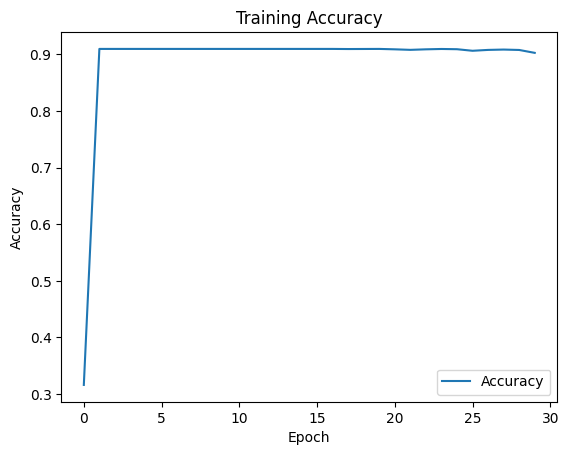

In [32]:
plot_metrics_train_graph(losses, 'Loss')
plot_metrics_train_graph(accuracies, 'Accuracy')

In [33]:
# Avaliando o modelo com dados de teste
test_feature_based_embeddings = np.array([generate_feature_based_embedding(text) for text in test_texts])
test_inputs = tokenizer(test_texts, padding=True, truncation=True, max_length=50, return_tensors="pt")

In [34]:
with torch.no_grad():
    test_outputs = model(**test_inputs).last_hidden_state
test_transformer_embeddings = test_outputs.numpy()

In [35]:
test_transformer_embeddings.shape

(2000, 50, 768)

In [36]:
reshape_test_transformer_embeddings = test_transformer_embeddings.reshape(test_transformer_embeddings.shape[0], -1)

In [37]:
reshape_test_transformer_embeddings.shape

(2000, 38400)

In [38]:
test_combined_embeddings = np.concatenate((test_feature_based_embeddings, reshape_test_transformer_embeddings), axis=1)

In [39]:
test_embeddings = torch.tensor(test_combined_embeddings, dtype=torch.float32)

In [40]:
test_embeddings.shape

torch.Size([2000, 38700])

In [41]:
with torch.no_grad():
    test_predictions = mlp_model(test_embeddings)

In [42]:
def plot_precision_recall_curve(recall, precision, avg_precision):
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (Avg Precision = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')

    plt.tight_layout()
    plt.show()

In [43]:
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')

In [44]:
def calculate_metrics(predictions, labels):
    rounded_predictions = np.round(predictions.numpy())
    precision, recall, _ = precision_recall_curve(labels, rounded_predictions)
    avg_precision = average_precision_score(labels, rounded_predictions)
    
    print("Métricas dados de Teste")
    print("Teste Accuracy:", accuracy_score(labels, rounded_predictions))
    print("Teste Loss:",log_loss(labels, rounded_predictions))
    print("Teste F1 Score:", f1_score(labels, rounded_predictions))
    print("Teste Recall de cada classe:", precision_score(labels, rounded_predictions))
    print("Teste Precision de cada classe:", recall_score(labels, rounded_predictions))
    print("Teste Avg de cada classe:", avg_precision)
    print(classification_report(labels, rounded_predictions))
    
    plot_precision_recall_curve(precision, recall, avg_precision)
    
    fpr, tpr, _ = roc_curve(labels, rounded_predictions)
    roc_auc = auc(fpr, tpr)
    plot_roc_curve(fpr, tpr, roc_auc)

Métricas dados de Teste
Teste Accuracy: 0.9065
Teste Loss: 1.4906131198573898
Teste F1 Score: 0.9508024204156802
Teste Recall de cada classe: 0.9084967320261438
Teste Precision de cada classe: 0.9972406181015453
Teste Avg de cada classe: 0.9084898425889856
              precision    recall  f1-score   support

           0       0.55      0.03      0.06       188
           1       0.91      1.00      0.95      1812

    accuracy                           0.91      2000
   macro avg       0.73      0.51      0.51      2000
weighted avg       0.87      0.91      0.87      2000



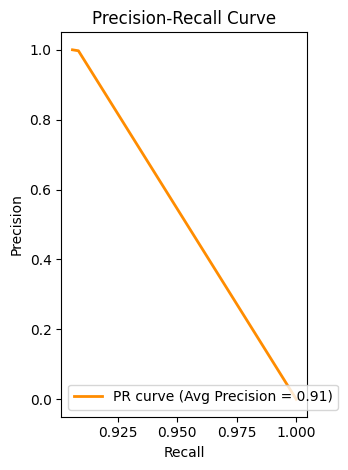

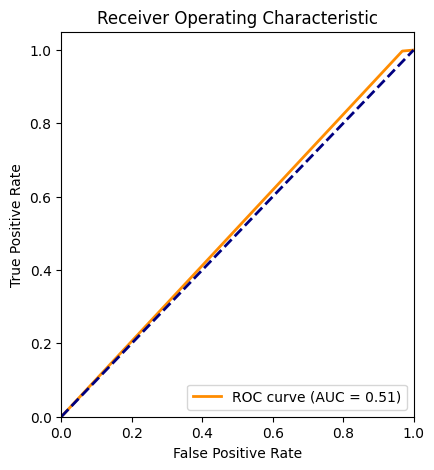

In [45]:
calculate_metrics(test_predictions, test_labels)